### Load Important Libraries

In [2]:
# PyTorch and Deep Learning
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50

# Data Science and Machine Learning
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Utilities
import random
import warnings

### Function to ingnore warnings

In [3]:
warnings.filterwarnings("ignore")

#### Setting all seeds to 42 to make results reproducible

In [4]:
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds()

### Custom Function to load all datasets

In [5]:
def load_datasets(path,file):
    datasets = []
    for i in range(1, 11):
        t = torch.load(path+str(i)+file)
        data, targets = t['data'], t.get('targets', None)
        datasets.append((data, targets))
    return datasets

### Function to extract features from image data (32x32x3) using ResNet50 model

In [6]:
def extract_features_from_datasets(datasets, model, transform, batch_size=32):
    model.eval() 
    all_features = []
    
    for data, targets in datasets:
        num_samples = data.shape[0]
        features = []
        
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_data = data[start_idx:end_idx]
        
            processed_images = [transform(image) for image in batch_data]
            inputs = torch.stack(processed_images).to(device)
            
            inputs = inputs.half() if torch.cuda.is_available() else inputs
            
            with torch.no_grad():
                batch_features = model(inputs).cpu().numpy()  
            features.append(batch_features)
        
        all_features.append(np.vstack(features))
    return all_features

## Custom LwPClassifier Class with update prototype function 

In [7]:
class LwPClassifier:
    def __init__(self, max_iters=100, tolerance=1e-4, decay=-0.011):
        self.max_iters = max_iters
        self.tolerance = tolerance
        self.decay = decay  
        self.prototypes = None
        self.prototype_labels = None

    def initialize_prototypes(self, train_features, train_targets):
        classes = np.unique(train_targets)
        self.prototypes = []
        self.prototype_labels = []

        for cls in classes:
            class_data = train_features[train_targets == cls]
            prototype = np.mean(class_data, axis=0)
            self.prototypes.append(prototype)
            self.prototype_labels.append(cls)

        self.prototypes = np.array(self.prototypes, dtype=float)
        self.prototype_labels = np.array(self.prototype_labels)

    def update_prototypes(self, train_features, train_labels):
        for iteration in range(self.max_iters):
            distances = cdist(train_features, self.prototypes, metric='euclidean')
            nearest_prototype_idx = np.argmin(distances, axis=1)
            assignments = self.prototype_labels[nearest_prototype_idx]

            new_prototypes = np.zeros_like(self.prototypes, dtype=float)
            for i, (prototype, label) in enumerate(zip(self.prototypes, self.prototype_labels)):
                assigned_data = train_features[(assignments == label) & (nearest_prototype_idx == i)]

                if len(assigned_data) > 0:
                    weights = 1 - distances[(assignments == label) & (nearest_prototype_idx == i), i]
                    weights /= weights.sum()
                    new_prototypes[i] = (assigned_data * weights[:, np.newaxis]).sum(axis=0)

                    new_prototypes[i] = self.decay * new_prototypes[i] + (1 - self.decay) * prototype
                else:
                    new_prototypes[i] = prototype 
            adaptive_tolerance = self.tolerance * (0.5 ** (iteration / self.max_iters))

            if np.linalg.norm(new_prototypes - self.prototypes) < adaptive_tolerance:
                print(f'Prototypes stabilized after {iteration + 1} iterations.')
                break

            self.prototypes = new_prototypes

    def predict(self, eval_features):
        distances = cdist(eval_features, self.prototypes, metric='euclidean')
        nearest_prototype_idx = np.argmin(distances, axis=1)
        return self.prototype_labels[nearest_prototype_idx]

## Custom Synthetica class
#### Analyzing the distribution of data and synthesizing data

In [8]:
class Synthetica:
    def __init__(self):
        self.scaler = StandardScaler()

    def analyze_distribution(self, data, labels, bandwidth=0.7):
        distributions = {}
        
        scaled_data = self.scaler.fit_transform(data)
        
        for class_label in np.unique(labels):
            class_data = scaled_data[labels == class_label]
            kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
            kde.fit(class_data)
            
            distributions[class_label] = {
                'kde': kde,
                'scaler': self.scaler
            }   
        return distributions

    def synthesize_data(self, distributions, n_samples_per_class=1000):
        synthetic_data = []
        synthetic_labels = []
        
        for class_label, dist_params in distributions.items():
            kde = dist_params['kde']
            scaler = dist_params['scaler']
            
            synthetic_samples = kde.sample(n_samples_per_class)
            synthetic_samples = scaler.inverse_transform(synthetic_samples)
            
            synthetic_data.append(synthetic_samples)
            synthetic_labels.extend([class_label] * n_samples_per_class)
        
        return np.vstack(synthetic_data), np.array(synthetic_labels)

## Custom SynthAdaptMix Class for Continual Domain Shift Problem 

In [9]:
class SynthAdaptMix:
    def __init__(self):
        self.n_components = 5
    
    def randmix(self, data, labels, mix_ratio_range=(0.5, 0.5), num_samples=1500,random_state=42): 
        random.seed(random_state)
        np.random.seed(random_state)
        unique_classes = np.unique(labels)
        augmented_features = []
        augmented_labels = []
    
        with torch.no_grad():
            for cls in unique_classes:
                mask = labels == cls
                class_features = data[mask]
            
                samples_per_class = num_samples // len(unique_classes)
                num_batches = (samples_per_class + len(class_features) - 1) // len(class_features)
                class_augmented = []
            
                for _ in range(num_batches):
                    generated_pairs = []
                    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                    class_features_tensor = torch.tensor(class_features, dtype=torch.float32, device=device)
                    N, F = class_features_tensor.shape
                
                    mixed_batch = torch.empty(min(samples_per_class, N), F, dtype=class_features_tensor.dtype, device=device)
                
                    for i in range(len(mixed_batch)):
                        while True:
                            pair = tuple(random.sample(range(N), 2))
                            if pair not in generated_pairs:
                                generated_pairs.append(pair)
                                break
                        idx1, idx2 = pair
                        alpha = np.random.uniform(mix_ratio_range[0], mix_ratio_range[1])
                        mixed_batch[i] = alpha * class_features_tensor[idx1] + (1 - alpha) * class_features_tensor[idx2]
                
                    class_augmented.append(mixed_batch.cpu().numpy())
            
                class_augmented = np.vstack(class_augmented)[:samples_per_class]
                augmented_features.append(class_augmented)
                augmented_labels.extend([cls] * samples_per_class)
    
        return np.vstack(augmented_features), np.array(augmented_labels)

    def train_classifier(self, train_features, train_targets):
        classifier = LwPClassifier()
        classifier.initialize_prototypes(train_features, train_targets)
        classifier.update_prototypes(train_features, train_targets)
        return classifier

    def predict_pseudo_labels(self, classifier, dataset):
        return classifier.predict(dataset)

    def evaluate(self, classifier, eval_dataset, eval_labels):
        predictions = classifier.predict(eval_dataset)
        accuracy = accuracy_score(eval_labels, predictions) * 100
        return accuracy
    
    def combine_data(self,data1,data1_labels,data2, data2_labels,cluster_size=2500):
        combined_features = np.concatenate([data1, data2])
        combined_labels = np.concatenate([data1_labels, data2_labels])
    
        kmeans = KMeans(n_clusters=cluster_size, random_state=42)
        kmeans.fit(combined_features)
    
        centers = kmeans.cluster_centers_
        distances = cdist(combined_features, centers)
        nearest_to_centers = np.argmin(distances, axis=0)
        selected_features = combined_features[nearest_to_centers]
        selected_labels = combined_labels[nearest_to_centers]
        return selected_features, selected_labels

## Loading Datasets

#### Loading training datasets using the function load_datasets

In [10]:
train_data_path1=f'C:/Users/shiva/Downloads/dataset/part_one_dataset/train_data/'
train_data_file1='_train_data.tar.pth'
train_datasets1 = load_datasets(train_data_path1,train_data_file1)
eval_data_path1=f'C:/Users/shiva/Downloads/dataset/part_one_dataset/eval_data/'
eval_data_file1='_eval_data.tar.pth'
eval_datasets1 = load_datasets(eval_data_path1,eval_data_file1)

#### Loading evaluation datasets using the function load_datasets

In [11]:
train_data_path2=f'C:/Users/shiva/Downloads/dataset/part_two_dataset/train_data/'
train_data_file2='_train_data.tar.pth'
train_datasets2 = load_datasets(train_data_path2,train_data_file2)
eval_data_path2=f'C:/Users/shiva/Downloads/dataset/part_two_dataset/eval_data/'
eval_data_file2='_eval_data.tar.pth'
eval_datasets2 = load_datasets(eval_data_path2,eval_data_file2)

#### Extracting features from datasets using the function extract_features_from_datasets 

It takes a long time to extract features from datasets, so we can save the extracted features in a file and load them when needed

In [12]:
# train_features1 = extract_features_from_datasets(train_datasets1, resnet, transform)
# eval_features1 = extract_features_from_datasets(eval_datasets1, resnet, transform)

# np.save('train_features_1to10.npy', train_features1)
# np.save('eval_features_1to10.npy', eval_features1)

In [13]:
# train_features2 = extract_features_from_datasets(train_datasets2, resnet, transform)
# eval_features2 = extract_features_from_datasets(eval_datasets2, resnet, transform)

# np.save('train_features_11to20.npy', train_features2)
# np.save('eval_features_11to20.npy', eval_features2)

#### Loading extracted features from files

In [14]:
train_features1 = np.load('train_features_1to10.npy')
eval_features1 = np.load('eval_features_1to10.npy')
train_features2 = np.load('train_features_11to20.npy')
eval_features2 = np.load('eval_features_11to20.npy')

#### Concatenating features from both datasets

In [15]:
train_features = np.concatenate((train_features1, train_features2), axis=0)
eval_features = np.concatenate((eval_features1, eval_features2), axis=0)

#### Loading Resnet50 model & Defining image transformation

In [16]:
resnet = resnet50(pretrained=True)
resnet.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet.to(device)
if torch.cuda.is_available():
    resnet.half()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Task1

### Training Models

In [17]:
model = SynthAdaptMix()
models = []
cluster_size=5000
labeled_features = train_features[0]
labeled_labels = train_datasets1[0][1]

augmented_features,augmented_labels=model.randmix(labeled_features,labeled_labels)

combined_features, combined_labels=model.combine_data(augmented_features,augmented_labels,labeled_features,labeled_labels)
current_distribution = Synthetica().analyze_distribution(combined_features, combined_labels,bandwidth=0.7)
classifier = model.train_classifier(combined_features, combined_labels)
models.append(classifier)

In [18]:
for i in range(2, 11):
    current_features = train_features[i - 1]
    pseudo_labels = model.predict_pseudo_labels(models[-1], current_features)
    synthetic_data, synthetic_labels = Synthetica().synthesize_data(current_distribution)

    augmented_data1 , augmented_labels1=model.randmix(synthetic_data,synthetic_labels)
    augmented_data2 , augmented_labels2=model.randmix(current_features,pseudo_labels)

    selected_features1, selected_labels1=model.combine_data(synthetic_data,synthetic_labels,current_features,pseudo_labels)
    selected_features2, selected_labels2=model.combine_data(augmented_data1,augmented_labels1,augmented_data2,augmented_labels2)
    selected_features, selected_labels=model.combine_data(selected_features1,selected_labels1,selected_features2,selected_labels2)

    classifier = model.train_classifier(selected_features, selected_labels)
    models.append(classifier)
    if i<3: a=0.7
    elif i<7:a=0.5
    elif i<9:a=0.1
    else:a=0.05
    current_distribution = Synthetica().analyze_distribution(selected_features, selected_labels,bandwidth=a)

### Evaluating Models

In [19]:
accuracy_matrix=np.zeros((20,20))
for i in range(1, 11):
    for j in range(i):
        accuracy = model.evaluate(models[i-1], eval_features[j], eval_datasets1[j][1])
        accuracy_matrix[i - 1, j] = accuracy
print("All models are evaluated")

All models are evaluated


### Visualization of accuracy matrix

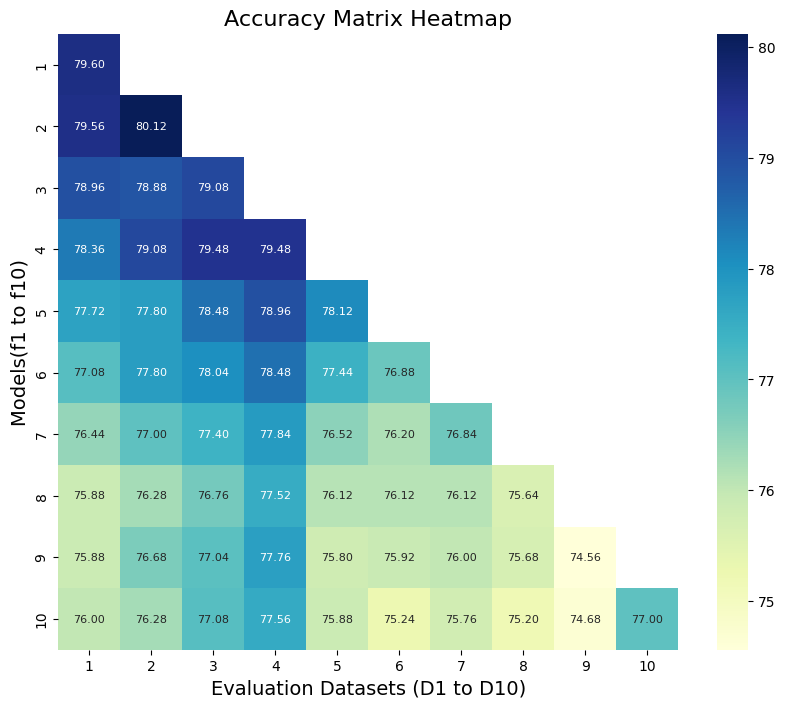

In [20]:
accuracy_subset=accuracy_matrix[:10,:10]
mask = accuracy_subset == 0
evaluation_results_min=np.min(accuracy_subset[accuracy_subset > 0])
evaluation_results_max=np.max(accuracy_subset)
df = pd.DataFrame(accuracy_subset)

plt.figure(figsize=(10, 8))
sns.heatmap(df, mask=mask, cmap="YlGnBu", annot=True, fmt=".2f", cbar=True, 
            vmin=evaluation_results_min, vmax=evaluation_results_max, annot_kws={"size": 8})
plt.ylabel("Models(f1 to f10)",fontsize=14)
plt.xlabel("Evaluation Datasets (D1 to D10)",fontsize=14)
plt.title("Accuracy Matrix Heatmap",fontsize=16)

plt.xticks(np.arange(len(df.columns)) + 0.5, np.arange(1, len(df.columns) + 1))
plt.yticks(np.arange(len(df.index)) + 0.5, np.arange(1, len(df.index) + 1))
plt.show()

In [21]:
accuracy_subset=accuracy_matrix[:10, :10] 
non_zero_accuracies = accuracy_subset[accuracy_subset > 0]
print(f"Mean Accuracy: {np.mean(non_zero_accuracies):.2f}%")
print(f"Standard Deviation: {np.std(non_zero_accuracies):.2f}%")
print(f"Minimum Accuracy: {np.min(non_zero_accuracies):.2f}%")
print(f"Maximum Accuracy: {np.max(non_zero_accuracies):.2f}%")

Mean Accuracy: 77.17%
Standard Deviation: 1.36%
Minimum Accuracy: 74.56%
Maximum Accuracy: 80.12%


## TASK 2

### Training Models

In [22]:
for i in range(11, 21):
    current_features = train_features[i - 1]
    pseudo_labels = model.predict_pseudo_labels(models[-1], current_features)
    synthetic_data, synthetic_labels = Synthetica().synthesize_data(current_distribution)

    augmented_data1 , augmented_labels1=model.randmix(synthetic_data,synthetic_labels)
    augmented_data2 , augmented_labels2=model.randmix(current_features,pseudo_labels)

    selected_features1, selected_labels1=model.combine_data(synthetic_data,synthetic_labels,current_features,pseudo_labels)
    selected_features2, selected_labels2=model.combine_data(augmented_data1,augmented_labels1,augmented_data2,augmented_labels1)
    selected_features, selected_labels=model.combine_data(selected_features1,selected_labels1,selected_features2,selected_labels2)

    classifier = model.train_classifier(selected_features, selected_labels)
    models.append(classifier)
    current_distribution = Synthetica().analyze_distribution(selected_features, selected_labels,bandwidth=0.2 if i<12 else 0.5)

### Evaluating models

In [23]:
for i in range(11, 21):
    for j in range(i):
        accuracy = model.evaluate(models[i-1], eval_features[j], eval_datasets1[j][1] if j<10 else eval_datasets2[j-10][1])
        accuracy_matrix[i - 1, j] = accuracy
print("All models are evaluated")

All models are evaluated


### Visualizing the Accuracy Matrix (for f11 to f20)

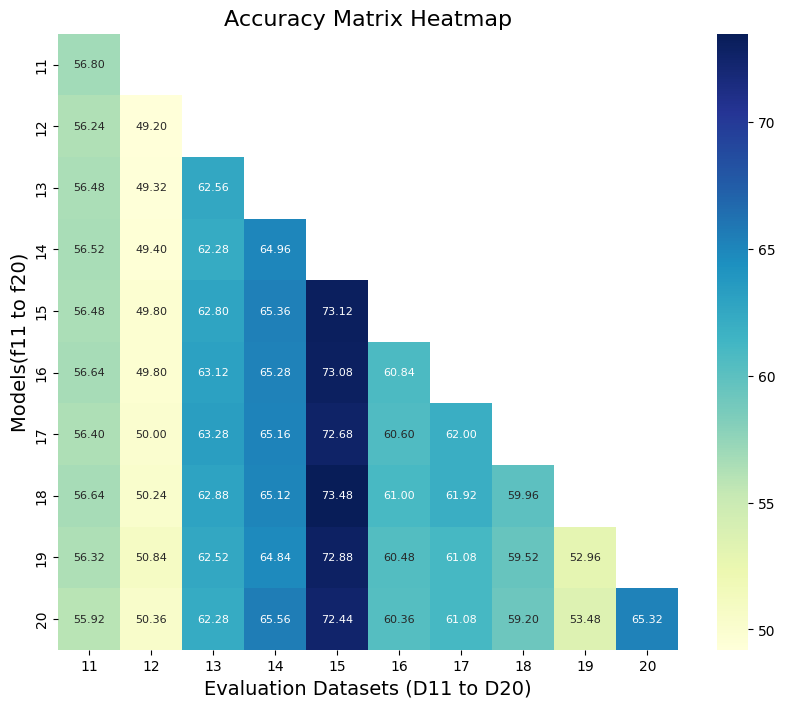

In [24]:
accuracy_subset=accuracy_matrix[10:20,10:20]
mask = accuracy_subset == 0
evaluation_results_min=np.min(accuracy_subset[accuracy_subset > 0])
evaluation_results_max=np.max(accuracy_subset)
df = pd.DataFrame(accuracy_subset)

plt.figure(figsize=(10, 8))
sns.heatmap(df, mask=mask, cmap="YlGnBu", annot=True, fmt=".2f", cbar=True, 
            vmin=evaluation_results_min, vmax=evaluation_results_max, annot_kws={"size": 8})
plt.ylabel("Models(f11 to f20)",fontsize=14)
plt.xlabel("Evaluation Datasets (D11 to D20)",fontsize=14)
plt.title("Accuracy Matrix Heatmap",fontsize=16)

plt.xticks(np.arange(len(df.columns)) + 0.5, np.arange(11, len(df.columns) + 11))
plt.yticks(np.arange(len(df.index)) + 0.5, np.arange(11, len(df.index) + 11))
plt.show()

### Calculating the mean, standard deviation and minimum accuracy for the accuracy matrix

In [25]:
accuracy_subset=accuracy_matrix[10:20, 10:20] 
non_zero_accuracies = accuracy_subset[accuracy_subset > 0]
print(f"Mean Accuracy: {np.mean(non_zero_accuracies):.2f}%")
print(f"Standard Deviation: {np.std(non_zero_accuracies):.2f}%")
print(f"Minimum Accuracy: {np.min(non_zero_accuracies):.2f}%")
print(f"Maximum Accuracy: {np.max(non_zero_accuracies):.2f}%")

Mean Accuracy: 60.16%
Standard Deviation: 6.66%
Minimum Accuracy: 49.20%
Maximum Accuracy: 73.48%


### Visualizing the Accuracy Matrix (for f1 to f20)

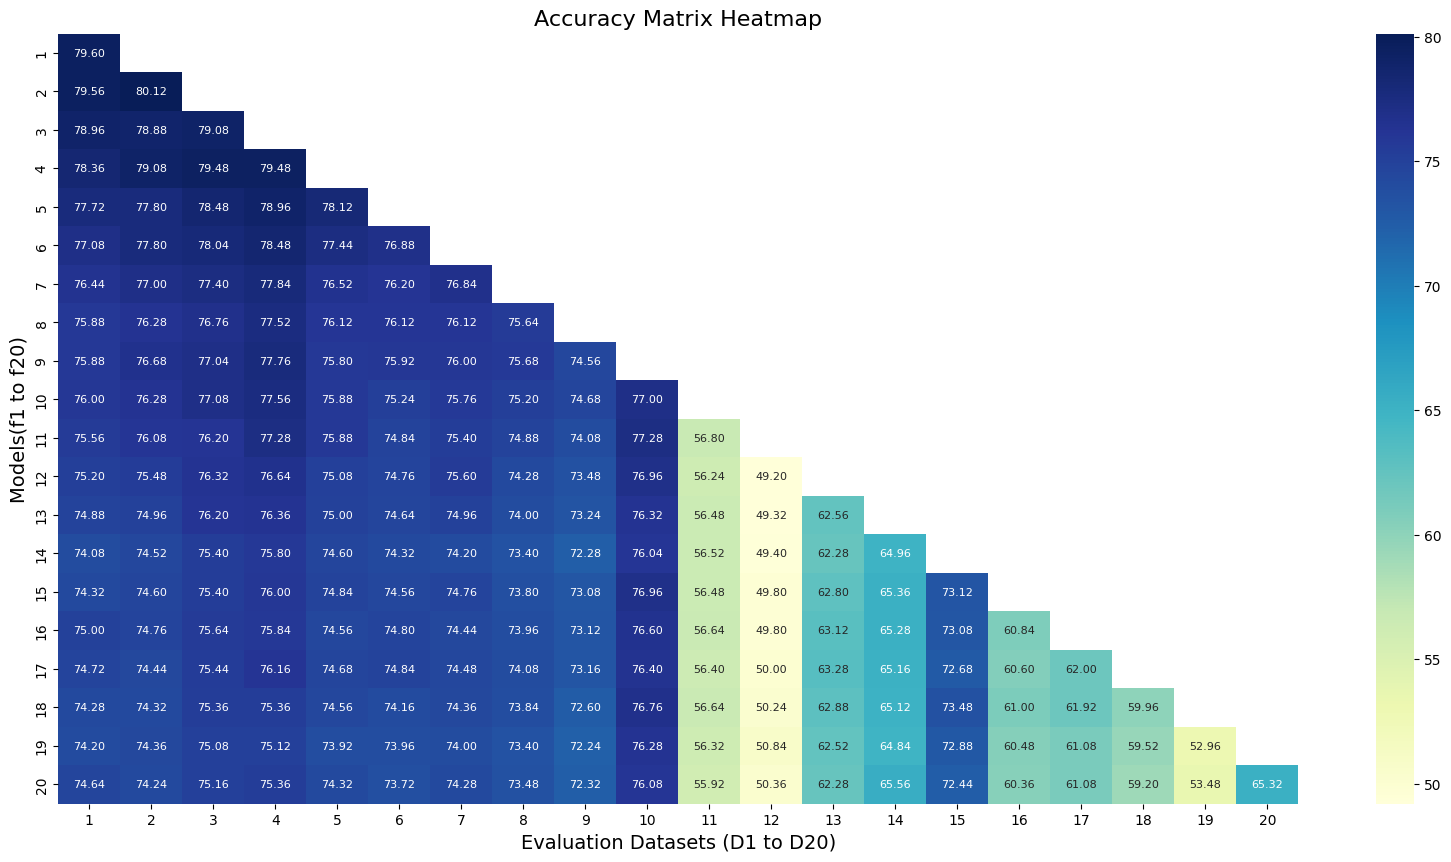

In [26]:
mask = accuracy_matrix == 0
evaluation_results_min=np.min(accuracy_matrix[accuracy_matrix > 0])
evaluation_results_max=np.max(accuracy_matrix)
df = pd.DataFrame(accuracy_matrix)

plt.figure(figsize=(20, 10))
sns.heatmap(df, mask=mask, cmap="YlGnBu", annot=True, fmt=".2f", cbar=True, 
            vmin=evaluation_results_min, vmax=evaluation_results_max, annot_kws={"size": 8})
plt.ylabel("Models(f1 to f20)",fontsize=14)
plt.xlabel("Evaluation Datasets (D1 to D20)",fontsize=14)
plt.title("Accuracy Matrix Heatmap",fontsize=16)

plt.xticks(np.arange(len(df.columns)) + 0.5, np.arange(1, len(df.columns) + 1))
plt.yticks(np.arange(len(df.index)) + 0.5, np.arange(1, len(df.index) + 1))
plt.show()

In [27]:
non_zero_accuracies = accuracy_matrix[accuracy_matrix > 0]
print(f"Mean Accuracy: {np.mean(non_zero_accuracies):.2f}%")
print(f"Standard Deviation: {np.std(non_zero_accuracies):.2f}%")
print(f"Minimum Accuracy: {np.min(non_zero_accuracies):.2f}%")
print(f"Maximum Accuracy: {np.max(non_zero_accuracies):.2f}%")

Mean Accuracy: 71.60%
Standard Deviation: 7.75%
Minimum Accuracy: 49.20%
Maximum Accuracy: 80.12%


In [28]:
for i in range(20):
    model_accuracies = accuracy_matrix[i, :i+1]
    non_zero_accuracies = model_accuracies[model_accuracies > 0]
    
    avg_accuracy = np.mean(non_zero_accuracies)
    max_accuracy = np.max(non_zero_accuracies)
    
    print(f"Model f{i+1:2d}: Avg = {avg_accuracy:.2f}%, Max = {max_accuracy:.2f}%")

Model f 1: Avg = 79.60%, Max = 79.60%
Model f 2: Avg = 79.84%, Max = 80.12%
Model f 3: Avg = 78.97%, Max = 79.08%
Model f 4: Avg = 79.10%, Max = 79.48%
Model f 5: Avg = 78.22%, Max = 78.96%
Model f 6: Avg = 77.62%, Max = 78.48%
Model f 7: Avg = 76.89%, Max = 77.84%
Model f 8: Avg = 76.31%, Max = 77.52%
Model f 9: Avg = 76.15%, Max = 77.76%
Model f10: Avg = 76.07%, Max = 77.56%
Model f11: Avg = 74.03%, Max = 77.28%
Model f12: Avg = 71.60%, Max = 76.96%
Model f13: Avg = 70.69%, Max = 76.36%
Model f14: Avg = 69.84%, Max = 76.04%
Model f15: Avg = 70.39%, Max = 76.96%
Model f16: Avg = 69.84%, Max = 76.60%
Model f17: Avg = 69.32%, Max = 76.40%
Model f18: Avg = 68.71%, Max = 76.76%
Model f19: Avg = 67.58%, Max = 76.28%
Model f20: Avg = 67.48%, Max = 76.08%
